In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Qiskit Imports
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Use mps for Apple Silicon Macs
if torch.backends.mps.is_available():
    device = torch.device("mps")
print(f"Using device: {device}")

Using device: mps


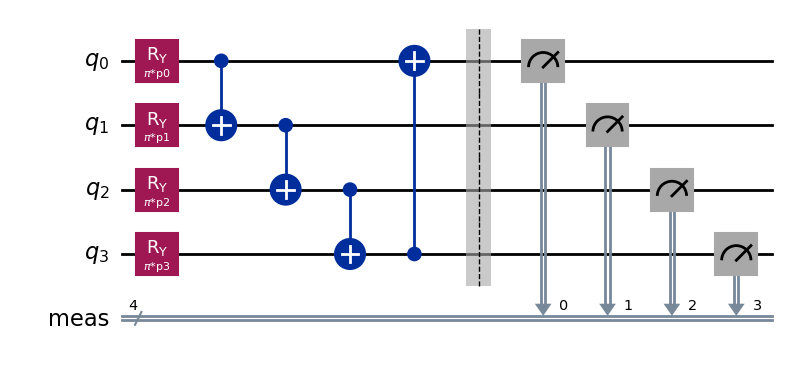

In [3]:
def create_quanvolution_circuit():
    """
    Creates a 4-qubit parameterized quantum circuit to act as a filter.
    Input: 4 pixels (2x2 patch).
    Output: 4 expectation values (feature channels).
    """
    n_qubits = 4
    qc = QuantumCircuit(n_qubits)

    # Parameters for the 4 input pixels
    # As per slides, we encode data into rotation angles (Angle Encoding)
    params = [Parameter(f'p{i}') for i in range(n_qubits)]

    # 1. Encoding Layer (Data re-uploading can be done here if needed)
    for i in range(n_qubits):
        qc.ry(np.pi * params[i], i) # Rotate by pixel value * pi

    # 2. Quanvolutional Layer (Entanglement)
    # Using CNOTs to create entanglement between pixels [cite: 167, 219]
    # This adds the "quantum advantage" by correlating features
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.cx(2, 3)
    qc.cx(3, 0) # Circular entanglement

    # 3. Measurement (Optional rotations could be added before this)
    # We measure all qubits. In a real QNN, these measures feed the classical layer.
    qc.measure_all()

    return qc, params

# Visualize the circuit
qc_example, _ = create_quanvolution_circuit()
qc_example.draw('mpl')

In [11]:
def quanv_layer(images, backend, shots=128):
    """
    Applies the quantum circuit as a convolution kernel over a batch of images.
    Fixed to wrap parameter values in lists for Qiskit Aer.
    """
    circuit, params = create_quanvolution_circuit()
    transpiled_circuit = transpile(circuit, backend)

    output_features = []

    for img in images:
        H, W = img.shape
        new_H, new_W = H // 2, W // 2

        # 1. Collect all patches (parameters) for this image
        binds = []
        for r in range(0, H - 1, 2):
            for c in range(0, W - 1, 2):
                patch = [
                    float(img[r, c]),     float(img[r, c+1]),
                    float(img[r+1, c]),   float(img[r+1, c+1])
                ]
                # FIX: Wrap the float values in a list -> [patch[i]]
                binds.append({params[i]: [patch[i]] for i in range(4)})

        # 2. Execute the job
        # We repeat the circuit to match the number of patches
        circuits_to_run = [transpiled_circuit] * len(binds)

        # Run efficiently in a single batch
        job = backend.run(circuits_to_run, parameter_binds=binds, shots=shots)
        result = job.result()
        counts_list = result.get_counts()

        # 3. Process results into expectation values
        feat_map = np.zeros((4, new_H, new_W))
        idx = 0

        for r in range(0, H - 1, 2):
            for c in range(0, W - 1, 2):
                count = counts_list[idx]

                # Calculate expectation value for each qubit
                for q in range(4):
                    # P(0) - P(1)
                    prob_0 = sum(v for k, v in count.items() if k[3-q] == '0') / shots
                    prob_1 = sum(v for k, v in count.items() if k[3-q] == '1') / shots
                    feat_map[q, r//2, c//2] = prob_0 - prob_1
                idx += 1

        output_features.append(feat_map)

    return torch.tensor(np.array(output_features), dtype=torch.float32)

In [12]:
# 1. Load Data
# We use a threshold to "Binarize" as requested in your project context
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((14, 14)), # Reduce size for faster simulation
    transforms.Lambda(lambda x: (x > 0.5).float()) # Binarization
])

# Load only a subset for demonstration purposes
n_samples = 100

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_subset = torch.utils.data.Subset(train_data, range(n_samples))
train_loader = DataLoader(train_subset, batch_size=10, shuffle=True)

test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_subset = torch.utils.data.Subset(test_data, range(50)) # 50 test samples
test_loader = DataLoader(test_subset, batch_size=10, shuffle=False)

print(f"Loaded {n_samples} training images and 50 test images.")

# 2. Pre-process with Quantum Circuit
# This step might take a minute or two
print("Starting Quantum Convolution Pre-processing...")
backend = AerSimulator()

def preprocess_dataset(loader):
    features = []
    labels = []
    for batch_idx, (data, target) in enumerate(loader):
        # Squeeze channel dim: (Batch, 1, 14, 14) -> (Batch, 14, 14)
        data = data.squeeze(1)

        # Apply Quantum Layer
        # This effectively extracts features using the circuit [cite: 835]
        q_features = quanv_layer(data.numpy(), backend)

        features.append(q_features)
        labels.append(target)
        print(f"Processed batch {batch_idx + 1}/{len(loader)}")

    return torch.cat(features), torch.cat(labels)

q_train_features, q_train_labels = preprocess_dataset(train_loader)
q_test_features, q_test_labels = preprocess_dataset(test_loader)

print(f"Quantum features shape: {q_train_features.shape}")
# Expected: (100, 4, 7, 7) -> 4 channels, half resolution due to stride 2

Loaded 100 training images and 50 test images.
Starting Quantum Convolution Pre-processing...
Processed batch 1/10
Processed batch 2/10
Processed batch 3/10
Processed batch 4/10
Processed batch 5/10
Processed batch 6/10
Processed batch 7/10
Processed batch 8/10
Processed batch 9/10
Processed batch 10/10
Processed batch 1/5
Processed batch 2/5
Processed batch 3/5
Processed batch 4/5
Processed batch 5/5
Quantum features shape: torch.Size([100, 4, 7, 7])


In [13]:
class HybridNet(nn.Module):
    def __init__(self):
        super(HybridNet, self).__init__()
        # Input is 4 channels (from 4 qubits), 7x7 spatial dim
        self.flatten = nn.Flatten()

        # Classical fully connected layers
        # The quantum circuit handled the "Convolutional" feature extraction part
        self.fc1 = nn.Linear(4 * 7 * 7, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 10) # 10 Output classes for MNIST

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = HybridNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

Epoch 0, Loss: 2.3267
Epoch 5, Loss: 1.3843
Epoch 10, Loss: 0.6321
Epoch 15, Loss: 0.2577


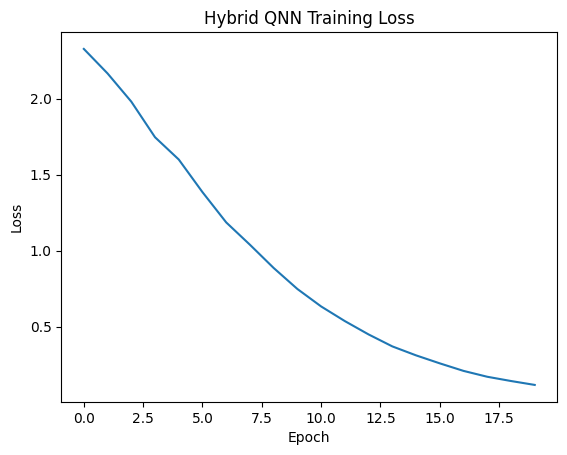

In [14]:
epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass using pre-processed quantum features
    output = model(q_train_features.to(device))
    loss = criterion(output, q_train_labels.to(device))

    # Backward pass
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Plot training curve
plt.plot(loss_list)
plt.title("Hybrid QNN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [16]:
model.eval()
with torch.no_grad():
    output = model(q_test_features.to(device))
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(q_test_labels.to(device).view_as(pred)).sum().item()
    accuracy = correct / len(q_test_labels)

print(f"\nTest Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 52.00%
